In [126]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

### Functions

In [236]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# 'it', 'is', 'in', 'for', 'do', 'does', 'did'
words_to_remove = ['what', 'how', 'why', 'when', 'where', 'which', 'if', 'can', 'could', 'would', 'should', 'must',
                   'explain', 'show', 'tell', 'help', 'write', 'make', 'create', 'see', 'are', 'was', 'were', 
                   'using', 'this', 'that', 'mean', 'means', 'need', 'want', 
                   'have', 'give', 'get', 'please', 'no', 'not', 'only', 'many', 'all']

for word in words_to_remove:
    if word in nlp.Defaults.stop_words: 
        nlp.Defaults.stop_words.remove(word)
        nlp.vocab[word].is_stop = False

words_to_add = ['i', 'you', 'be', 'this', 'that', 'it', 'in', 'for', 'do', 'does', 'did']
for word in words_to_add:
    nlp.vocab[word].is_stop = True
    

def clean_df(df, filter_state=False, state="CLOSED", merged=False):
    df = df.drop_duplicates(subset=['Prompt'], keep='first')
    
    # Replace newlines with empty space and strip
    df.loc[:, 'difference'] = df['difference'].str.replace(r'\n+', ' ', regex=True).str.strip()

    # Drop rows where 'difference' is an empty string (indicates prompt was just code)
    df = df[df['difference'].notna() & (df['difference'] != '')]

    # Remove URLs and file paths
    df.loc[:, 'difference'] = df['difference'].apply(lambda text: re.sub(r'http\S+|www\S+|https\S+', '', text))
    df.loc[:, 'difference'] = df['difference'].apply(lambda text: re.sub(r'[a-zA-Z]:\\[\\\S|*\S]?.*|/\S+', '', text))

    if filter_state:
        df = df[df['State'] == state].reset_index(drop=True)

    if merged:
        df = df.groupby('conversation_id').agg({
            'difference': lambda x: ' '.join(x.dropna().astype(str)) if not x.dropna().empty else None,  # avoid empty groups
            'State': 'first',       # keep first value of State (same for all prompts in a conversation)
            'numPrompts': 'first',  # keep first value of numPrompts
        }).reset_index()

    return df
    

def custom_tokenizer(text):
    # Remove common code terms
    code_terms = {
        'github', 'com', 'http', 'https', 'localhost', 'api',
        'json', 'xml', 'html', 'css', 'js', 'php', 'sql',
        'readme', 'md', 'txt', 'pdf', 'doc', 'docx'
    }

    # Process the text with SpaCy (convert to lowercase before processing)
    doc = nlp(text.lower())
    
    # Extract tokens (using lemmatization)
    tokens = [token.lemma_ for token in doc if token.is_alpha 
              and not token.is_space 
              and not token.is_punct
              and not token.is_stop
              and token.text not in code_terms
              and token.pos_ in ["ADJ", "NOUN", "VERB", "AUX", "PRON", "ADV", "DET", "IN", "SCONJ", "INTJ", "ADP", "PART"]]
    
    return tokens


def get_tokenized(data):
    tokenized_data = []
    
    for text in data:
        tokens = custom_tokenizer(text)
        tokenized_data.append(tokens)

    return tokenized_data

### Cleaning

In [205]:
# read data
df = pd.read_csv('NL_code_difference_clean.csv', na_values=['', 'nan'])

df_full = clean_df(df)
df_open = clean_df(df, True, "OPEN")
df_closed = clean_df(df, True)
df_merged = clean_df(df, merged=True)
df_closed_merged = clean_df(df, True, True)

In [237]:
# load data into list
data = list(df_closed["difference"])
tokenized_data = get_tokenized(data)

# Build dictionary of (token, ID) mappings
dct = corpora.Dictionary(tokenized_data)

bad_ids = [id for id, token in dct.items() if token == 'be']
dct.filter_tokens(bad_ids)

# Print vocab size
print('Size of vocabulary before filtering:', len(dct))

# Filter overly low and high frequency tokens
dct.filter_extremes(no_below=5, no_above=0.5)

# Print vocab size
print('\nSize of vocabulary after filtering:', len(dct))

# Example mappings
print("\nExample mappings:", [(i,dct.token2id[i]) for i in tokenized_data[0][:10]])

Size of vocabulary before filtering: 1568

Size of vocabulary after filtering: 222

Example mappings: [('could', 0), ('create', 1), ('unit', 4), ('test', 3), ('function', 2)]


In [238]:
# Bag-of-Words sparse matrix
bow = [dct.doc2bow(i) for i in tokenized_data]

# Train LDA model
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)

# Print generated topics
# lda_model.print_topics()

In [239]:
# Get topics
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))

# Print topic proportion in corpus
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 12.0%
Topic 1 proportion: 10.2%
Topic 2 proportion: 11.1%
Topic 3 proportion: 13.3%
Topic 4 proportion: 6.8%
Topic 5 proportion: 8.1%
Topic 6 proportion: 13.4%
Topic 7 proportion: 6.6%
Topic 8 proportion: 11.0%
Topic 9 proportion: 7.4%


In [240]:
# Return top topics in a song
def get_top_topics(idx, min_prob):

    # Sort topics from highest to lowest frequency
    topics = sorted(lda_model.get_document_topics(bow[idx], minimum_probability=min_prob), key=lambda tup: tup[1])[::-1]

    # Get word distribution for each topic
    pairs = [lda_model.show_topic(pair[0]) for pair in topics]
    topic_words = [[pair[0] for pair in topic] for topic in pairs]

    return pd.DataFrame({'Major Topics': topics,'Topic Words': topic_words})


# Example
idx = 7
display(get_top_topics(idx, 0.25))
print(data[idx][:300])

,Major Topics,Topic Words
0,"(3, 0.9401257)","[not, like, would, file, get, work, user, have..."


I already have the plugin ready and working at  . with the following manifest: note that this is working and the variables are filled in upon request. please show me how I would authenticate this on the nextjs passport flow


In [241]:
# Coherence score (closer to -14 is better)
coherence_model = models.coherencemodel.CoherenceModel(model=lda_model, texts=tokenized_data, dictionary=dct, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

Coherence Score: -5.6321


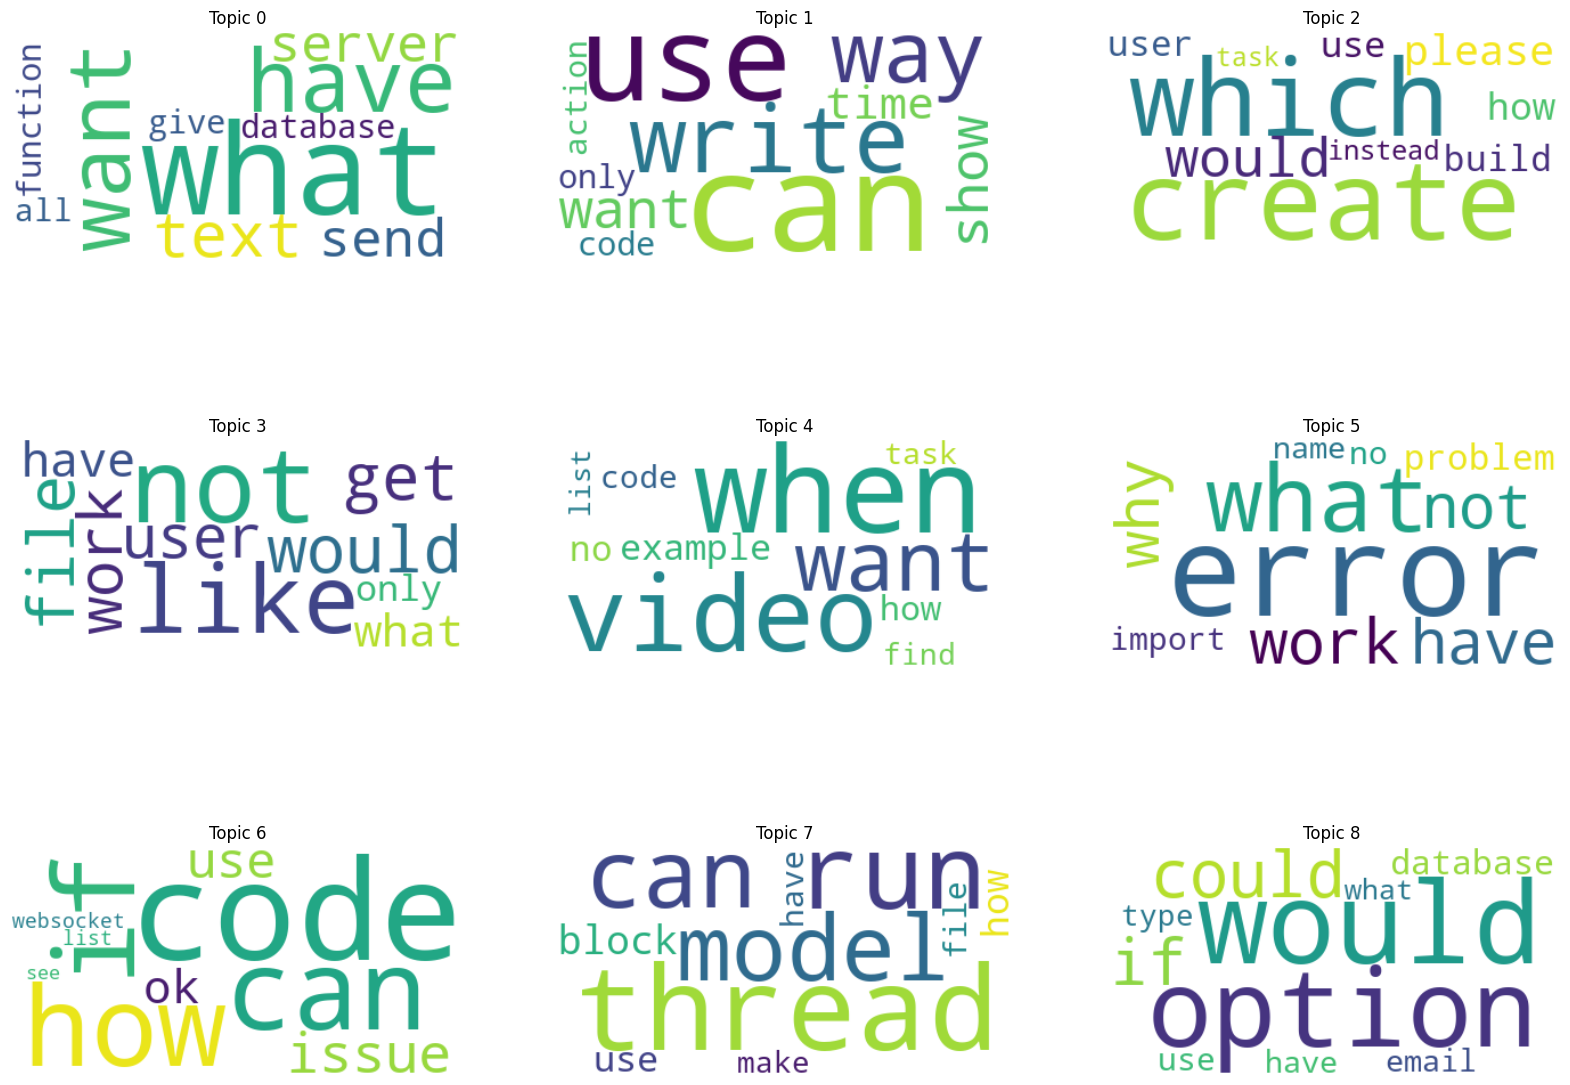

In [244]:
# Plot word clouds for each topic
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(3, 3, figsize=(20,15))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_model.show_topic(i))
    word_cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(word_cloud, interpolation='bilinear')
    plt.gca().set_title(f'Topic {i}')
    plt.gca().axis('off')
plt.show()

In [172]:
n = 90
for i in range(n,n+10):
    print(data[i])
    print(tokenize(data[i]))
    print('\n')

Would it be reasonable for me to disassociate the verification model from the user? In the case of registration, I don't have a user yet. I'm thinking for registration I could just lookup the verification by the otp which would then allow me to create a new user by the identifier (which would be the email). Would doing this limit the usefulness of this model?
['would', 'it', 'reasonable', 'for', 'disassociate', 'verification', 'model', 'user', 'in', 'case', 'registration', 'do', 'have', 'user', 'think', 'for', 'registration', 'could', 'lookup', 'verification', 'otp', 'which', 'would', 'allow', 'create', 'new', 'user', 'identifier', 'which', 'would', 'email', 'would', 'this', 'limit', 'usefulness', 'this', 'model']


For point 3, I could make the identifier be equal to the User ID. But that may be a bit ambiguous which makes me think bringing back the relational model for the `type` field would be useful. Which approach do you think strikes the best balance between complexity and flexib

In [229]:
test = "do"

print(nlp.vocab[test].is_stop)

tokens = custom_tokenizer(test)

doc = nlp(test)
print(doc[0].pos_)

False
VERB
